# Qiskit 101 Tutorial
* Level: Beginner



<details>
  <summary><b>Package versions</b></summary>

  The code on this page was developed using the following requirements.
  We recommend using these versions or newer.

  ```
  qiskit[all]~=2.1.1
  qiskit-ibm-runtime~=0.40.1
  ```
</details>



This example contains two parts. You will first create a simple quantum program and run it on a quantum processing unit (QPU).  Because actual quantum research requires much more robust programs, in the second section ([Scale to large numbers of qubits](#scale-to-large-numbers-of-qubits)), you will scale the simple program up to utility level.



## Before you begin
qBraid Lab
Qiskit users can use qBraid’s preconfigured Python environments by following these instructions. For more information, see the qBraid Docs.

* Set up an qBraid(https://docs.qbraid.com/home/account) free account.
* Create a Lab environment.
* Launch qBraid Lab, click the ENVS icon on the right, click + ADD at the top of the new sidebar, and search for Qiskit. Click the version you want to use, then click Install.
* Create a Jupyter notebook by clicking Python 3 [Qiskit] in the Notebook section.
* You can install any additional Python packages (Such as Qiskit v1.2) in a notebook cell by running %pip install [package_name]. For more information, see the Pip (magic) commands topic.



## Create and run a simple quantum program



The four steps to writing a quantum program using Qiskit patterns are:

1.  Map the problem to a quantum-native format.

2.  Optimize the circuits and operators.

3.  Execute using a quantum primitive function.

4.  Analyze the results.

### Step 1. Map the problem to a quantum-native format

In a quantum program, *quantum circuits* are the native format in which to represent quantum instructions, and *operators* represent the observables to be measured. When creating a circuit, you'll usually create a new [`QuantumCircuit`](/docs/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) object, then add instructions to it in sequence.



The following code cell creates a circuit that produces a *Bell state,* which is a state wherein two qubits are fully entangled with each other.

<Admonition type="note" title="Note: bit ordering">
  The Qiskit SDK uses the LSb 0 bit numbering where the $n^{th}$ digit has value $1 \ll n$ or $2^n$. For more details, see the [Bit-ordering in the Qiskit SDK](/docs/guides/bit-ordering) topic.
</Admonition>



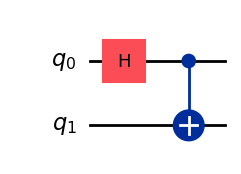

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which
# display the output of the last line of each cell.
# If you're running this in a script, use `print(qc.draw())` to
# print a text drawing.
qc.draw("mpl")

See [`QuantumCircuit`](/docs/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) in the documentation for all available operations.



When creating quantum circuits, you must also consider what type of data you want returned after execution. Qiskit provides two ways to return data: you can obtain a probability distribution for a set of qubits you choose to measure, or you can obtain the expectation value of an observable. Prepare your workload to measure your circuit in one of these two ways with [Qiskit primitives](/docs/guides/get-started-with-primitives) (explained in detail in [Step 3](#step-3-execute-using-the-quantum-primitives)).

This example measures expectation values by using the `qiskit.quantum_info` submodule, which is specified by using operators (mathematical objects used to represent an action or process that changes a quantum state). The following code cell creates six two-qubit Pauli operators: `IZ`, `IX`, `ZI`, `XI`, `ZZ`, and `XX`.



In [3]:
# Set up six different observables.

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

<Admonition type="note" title="Operator Notation">
  Here, something like the `ZZ` operator is a shorthand for the tensor product $Z\otimes Z$, which means measuring Z on qubit 1 and Z on qubit 0 together, and obtaining information about the correlation between qubit 1 and qubit 0. Expectation values like this are also typically written as $\langle Z_1 Z_0 \rangle$.

  If the state is entangled, then the measurement of $\langle Z_1 Z_0 \rangle$ should be different from the measurement of $\langle I_1 \otimes Z_0 \rangle \langle Z_1 \otimes I_0 \rangle$. For the specific entangled state created by our circuit described above, the measurement of $\langle Z_1 Z_0 \rangle$ should be 1 and the measurement of $\langle I_1 \otimes Z_0 \rangle \langle Z_1 \otimes I_0 \rangle$ should be zero.
</Admonition>



<span id="optimize" />

### Step 2. Optimize the circuits and operators

When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's [Instruction Set Architecture (ISA)](/docs/guides/transpile#instruction-set-architecture) and must consider the device's basis gates and qubit connectivity.

The following code instantiates a real device to submit a job to and transforms the circuit and observables to match that backend's ISA. It requires that you have already [saved your credentials](/docs/guides/cloud-setup)



In [4]:
your_api_key = "8aXYGQ5kt_jVPOG_jTo3jlulkQjGqgzsJTxhNzHALLWY"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/caacb916847a44a78782ebcf8733f690:dd9d63d8-857d-4ee9-afb1-1c50b8ecc8d3::"

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=your_api_key,
    instance=your_crn,
    name="fallfest-2025",
    overwrite=True
)

# # Check that the account has been saved properly
service = QiskitRuntimeService(name="fallfest-2025")
print(service.saved_accounts())

management.get:WARNING:2025-10-04 20:57:57,569: Loading saved account: fallfest-2025


{'fallfest-2025': {'channel': 'ibm_cloud', 'url': 'https://cloud.ibm.com', 'token': '8aXYGQ5kt_jVPOG_jTo3jlulkQjGqgzsJTxhNzHALLWY', 'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/caacb916847a44a78782ebcf8733f690:dd9d63d8-857d-4ee9-afb1-1c50b8ecc8d3::', 'verify': True, 'private_endpoint': False}}


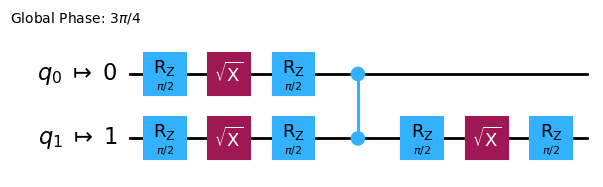

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)

### Step 3. Execute using the quantum primitives

Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the `Estimator` class. `Estimator` is one of two [primitives](/docs/guides/get-started-with-primitives); the other is `Sampler`, which can be used to get data from a quantum computer.  These objects possess a `run()` method that executes the selection of circuits, observables, and parameters (if applicable), using a [primitive unified bloc (PUB).](/docs/guides/primitives#sampler)



In [6]:
# Construct the Estimator instance.

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d3gs59c1nk1s739nua50


After a job is submitted, you can wait until either the job is completed within your current python instance, or use the `job_id` to retrieve the data at a later time.  (See the [section on retrieving jobs](/docs/guides/monitor-job#retrieve-job-results-at-a-later-time) for details.)

After the job completes, examine its output through the job's `result()` attribute.



In [7]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

<Admonition type="note" title="Alternative: run the example using a simulator">
  When you run your quantum program on a real device, your workload must wait in a queue before it runs. To save time, you can instead use the following code to run this small workload on the [`fake_provider`](../api/qiskit-ibm-runtime/fake-provider) with the Qiskit Runtime local testing mode. Note that this is only possible for a small circuit. When you scale up in the next section, you will need to use a real device.

  ```python

  # Use the following code instead if you want to run on a simulator:

  from qiskit_ibm_runtime.fake_provider import FakeFez
  backend = FakeFez()
  estimator = Estimator(backend)

  # Convert to an ISA circuit and layout-mapped observables.

  pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
  isa_circuit = pm.run(qc)
  mapped_observables = [
      observable.apply_layout(isa_circuit.layout) for observable in observables
  ]

  job = estimator.run([(isa_circuit, mapped_observables)])
  result = job.result()

  # This is the result of the entire submission.  You submitted one Pub,
  # so this contains one inner result (and some metadata of its own).

  job_result = job.result()

  # This is the result from our single pub, which had five observables,
  # so contains information on all five.

  pub_result = job.result()[0]
  ```
</Admonition>



### Step 4. Analyze the results

The analyze step is typically where you might post-process your results using, for example, measurement error mitigation or zero noise extrapolation (ZNE). You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general, this step is specific to your problem.  For this example, plot each of the expectation values that were measured for our circuit.

The expectation values and standard deviations for the observables you specified to Estimator are accessed through the job result's `PubResult.data.evs` and `PubResult.data.stds` attributes. To obtain the results from Sampler, use the `PubResult.data.meas.get_counts()` function, which will return a `dict` of measurements in the form of bitstrings as keys and counts as their corresponding values. For more information, see [Get started with Sampler.](/docs/guides/get-started-with-primitives#get-started-with-sampler)



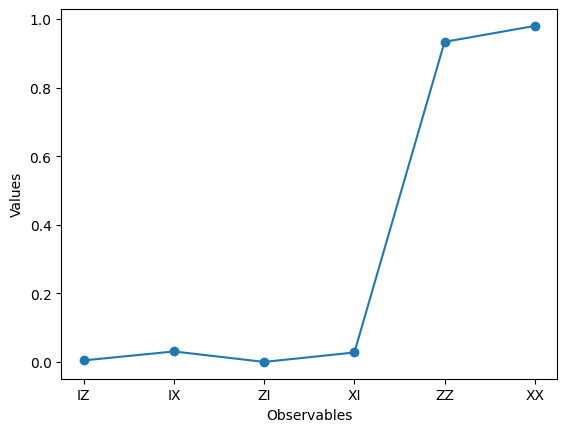

In [8]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

Notice that for qubits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (`XX` and `ZZ`) are 1. This is a hallmark of quantum entanglement.



The previous plot shows that as the distance between qubits increases, the signal decays because of the presence of noise.



## Next steps

<Admonition type="tip" title="Recommendations">
  *   Learn how to [build circuits](/docs/guides/map-problem-to-circuits) in more detail.
  *   Try the [Ground-state energy estimation of the Heisenberg chain with VQE](/docs/tutorials/spin-chain-vqe) tutorial.
</Admonition>



© IBM Corp., 2017-2025